#### Desafío 2 - Segmentación de Clientes
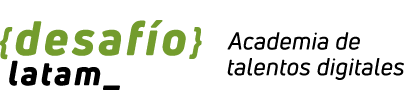
---
---

**Nombre:** Ignacio Robles  
**Sección:** G-115  

En este desafío se aplicarán técnicas de aprendizaje no supervisado para segmentar clientes del supermercado *FreshMart*, utilizando información histórica de compras.  

El objetivo es identificar grupos de clientes con comportamientos similares, generar variables relevantes a nivel cliente (como RFM), aplicar algoritmos de clustering y evaluar la calidad de los segmentos obtenidos.  


---

#### Importaciones

---

In [1]:
# Librerías principales
import pandas as pd
import numpy as np

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocesamiento
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Clustering
from sklearn.cluster import KMeans
import skfuzzy as fuzz
from sklearn.cluster import AgglomerativeClustering

# Métricas
from sklearn.metrics import silhouette_score, davies_bouldin_score


# Configuración gráfica
plt.style.use('default')
%matplotlib inline

# Fijamos formatos para mejorar la visualización de dataframes en nuestro cuaderno
pd.set_option("display.max_columns", None)      # muestra todas las columnas
pd.set_option("display.max_rows", None)         # todas las filas
pd.set_option("display.width", None)            # clave: usa el ancho real del notebook
pd.set_option("display.max_colwidth", None)     # no corta strings largos
pd.set_option("display.expand_frame_repr", False)

---

#### 1. Análisis de calidad de datos y exploración

---

Leer el archivo **Retail_Invoices.xlsx** y realizar un análisis de calidad de datos, para definir la calidad de la data entregada considerando valores anómalos, valores faltantes, duplicados u otros problemas detectados.

La data contiene los siguientes campos:

- InvoiceNo: Número identificador de cada boleta  
- InvoiceDate: Fecha de la boleta  
- CustomerId: Número identificador de cada cliente  
- Quantity: Cantidad total de unidades compradas  
- price_total: Precio total de la boleta  
- StockCode: Cantidad de unidades diferentes compradas  

Se solicita:

- Revisar tipos de datos.
- Detectar valores faltantes.
- Identificar valores anómalos.
- Revisar duplicados.
- Realizar limpieza si es necesario.
- Realizar un análisis exploratorio con gráficos de distribución y análisis de correlaciones.

Documentar cualquier supuesto realizado.


In [2]:
# Lectura del archivo
df = pd.read_excel('Retail_Invoices.xlsx')

# Exploración inicial
print("Imprimimos las primeras 5 filas del DataFrame:")
print(df.head())
print(f"\n Información general del DataFrame:")
print(df.info())
print(f"\n Estadísticas descriptivas del DataFrame:")
print(df.describe())

Imprimimos las primeras 5 filas del DataFrame:
  InvoiceNo InvoiceDate  CustomerID  Quantity  price_total  StockCode
0    536365  2010-12-01       17850        40       139.12          7
1    536366  2010-12-01       17850        12        22.20          2
2    536367  2010-12-01       13047        83       278.73         12
3    536368  2010-12-01       13047        15        70.05          4
4    536369  2010-12-01       13047         3        17.85          1

 Información general del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22190 entries, 0 to 22189
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   InvoiceNo    22190 non-null  object        
 1   InvoiceDate  22190 non-null  datetime64[ns]
 2   CustomerID   22190 non-null  int64         
 3   Quantity     22190 non-null  int64         
 4   price_total  22190 non-null  float64       
 5   StockCode    22190 non-null  int64      

1. Con el .info() revisamos que el DataFrame no tenga valores nulos. **Descartamos exploración posterior de nulos**.
2. Con el mismo método revisamos los tipos de datos presentes en nuestro DataFrame. Todos los tipos de datos son adecuados. 

----
#### Gráficos de distribución

----

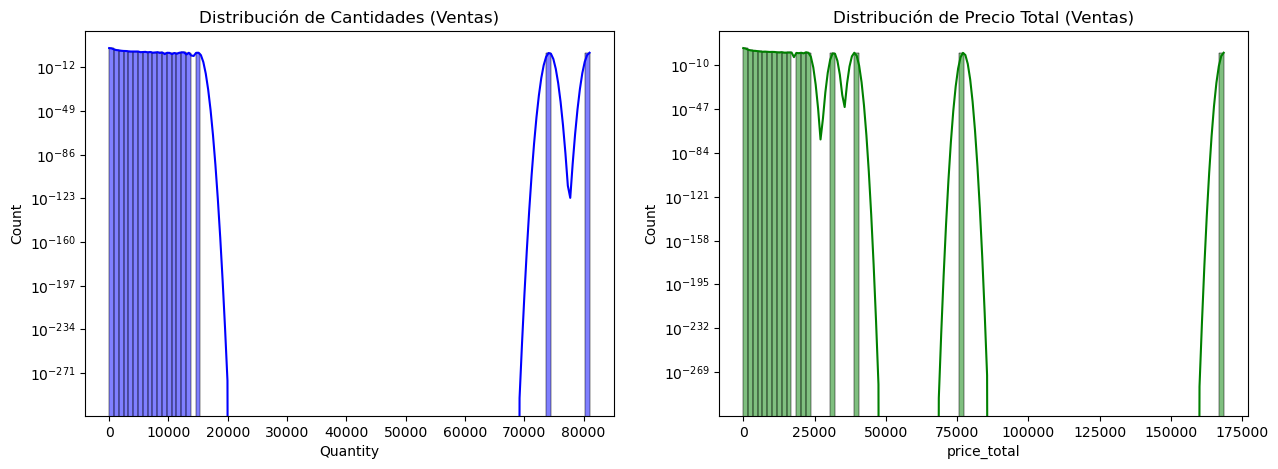

In [3]:
# Filtramos solo para la visualización (Ventas vs Devoluciones)
ventas = df[df['Quantity'] > 0]
devoluciones = df[df['Quantity'] < 0]

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Distribución de Cantidades
sns.histplot(ventas['Quantity'], bins=100, ax=ax[0], color='blue', kde=True)
ax[0].set_yscale('log') # ESCALA LOGARÍTMICA: Crucial para ver los outliers
ax[0].set_title('Distribución de Cantidades (Ventas)')

# Distribución de Precios Totales
sns.histplot(ventas['price_total'], bins=100, ax=ax[1], color='green', kde=True)
ax[1].set_yscale('log')
ax[1].set_title('Distribución de Precio Total (Ventas)')

plt.show()

Para continuar con el análisis, debemos eliminar el "ruido", los valores negativos que significan devoluciones, así como estandarizar los valores para el posterior procesamiento y modelado.

In [4]:
# 1. Identificar y eliminar facturas canceladas (las que tienen Quantity < 0)
# Esto limpia tanto la cantidad negativa como el precio negativo asociado
df_clean = df[df['Quantity'] > 0].copy()

# 2. Eliminar registros con Precio 0 (a veces son regalos o errores que ensucian el promedio)
df_clean = df_clean[df_clean['price_total'] > 0]

print(f"Registros originales: {len(df)}")
print(f"Registros después de la limpieza: {len(df_clean)}")

Registros originales: 22190
Registros después de la limpieza: 18532


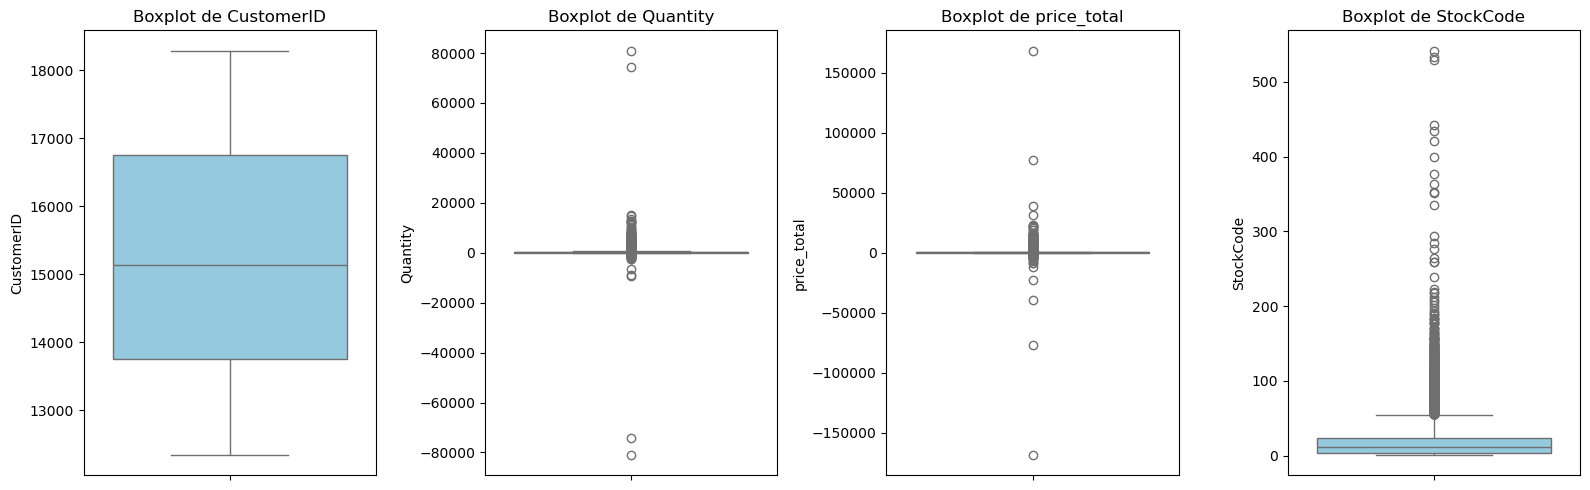

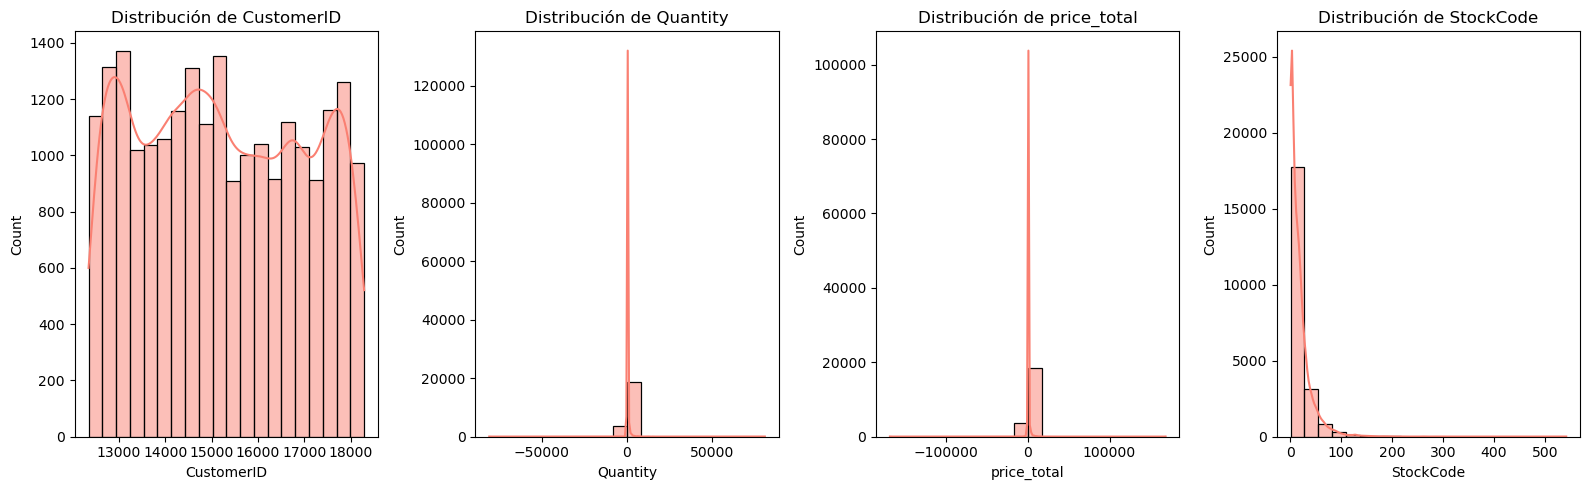

In [5]:

# Seleccionamos solo las columnas numéricas
cols_numericas = df_clean.select_dtypes(include=['number']).columns
n_cols = len(cols_numericas)

# 1. Generar Boxplots (para ver la dispersión y si aún quedan outliers)
plt.figure(figsize=(4 * n_cols, 5))
for i, col in enumerate(cols_numericas, 1):
    plt.subplot(1, n_cols, i)
    sns.boxplot(y=df[col], color='skyblue')
    plt.title(f'Boxplot de {col}')
plt.tight_layout()

# 2. Generar Histogramas con KDE (para ver la distribución de los datos)
plt.figure(figsize=(4 * n_cols, 5))
for i, col in enumerate(cols_numericas, 1):
    plt.subplot(1, n_cols, i)
    sns.histplot(df[col], kde=True, color='salmon', bins=20)
    plt.title(f'Distribución de {col}')
plt.tight_layout()

plt.show()

#### Análisis general

Luego de revisar los gráficos, nos damos cuenta de que la distribución de los datos está fuertemente influenciada por valores extremos, devoluciones y data que debemos limpiar si queremos un buen desempeño de nuestros modelos de clusterización. Estos outliers amplían la escala de las visualizaciones y dificultan el análisis del comportamiento típico de los clientes.

#### Limpieza de datos

Es necesario aplicar un filtro basado en el Rango Intercuartílico (IQR) para reducir el impacto de los valores atípicos. Esto permitirá “hacer zoom” en la distribución principal y obtener una visión más representativa del cliente promedio.

#### Validación de negocio

Antes de eliminar valores extremadamente altos (por ejemplo, montos cercanos a 150k en `price_total`), es importante validar si corresponden a errores de registro o a clientes estratégicos de alto valor. No todos los outliers son ruido; algunos pueden representar oportunidades clave.

#### Estrategia de segmentación

Dado el comportamiento diferenciado de los valores extremos, podría ser conveniente separar el análisis entre clientes minoristas y mayoristas. Esto permitiría entender mejor cada grupo sin que uno distorsione el análisis del otro.

Columna 'Quantity': Se eliminaron 1349 filas como outliers.
Columna 'price_total': Se eliminaron 791 filas como outliers.


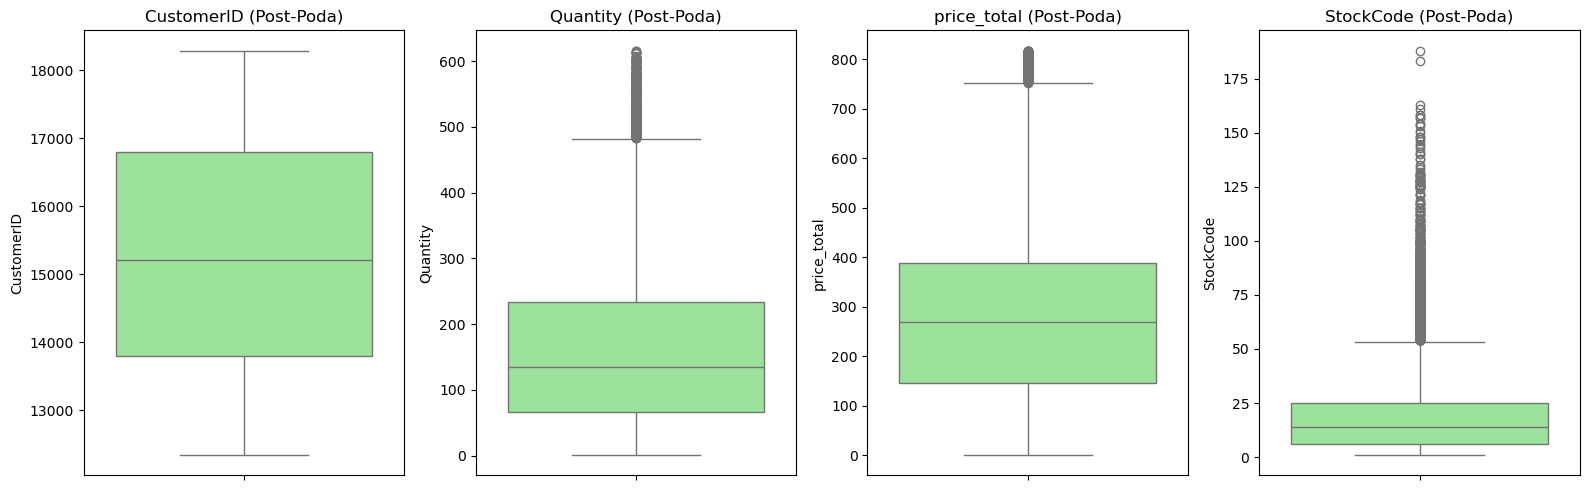

In [6]:
df_final = df_clean.copy()
columnas_criticas = ['Quantity', 'price_total']

for col in columnas_criticas:
        # Calcular Q1 (percentil 25) y Q3 (percentil 75)
        Q1 = df_final[col].quantile(0.25)
        Q3 = df_final[col].quantile(0.75)
        IQR = Q3 - Q1
        
        # Definir límites
        limite_inferior = Q1 - 1.5 * IQR
        limite_superior = Q3 + 1.5 * IQR
        
        # Aplicar el filtro
        antes = len(df_final)
        df_final = df_final[(df_final[col] >= limite_inferior) & (df_final[col] <= limite_superior)]
        despues = len(df_final)
        
        print(f"Columna '{col}': Se eliminaron {antes - despues} filas como outliers.")

cols = df_final.select_dtypes(include=['number']).columns

plt.figure(figsize=(16, 5))
for i, col in enumerate(cols, 1):
    plt.subplot(1, len(cols), i)
    sns.boxplot(y=df_final[col], color='lightgreen')
    plt.title(f'{col} (Post-Poda)')
plt.tight_layout()
plt.show()

#### Resumen: Poda de Outliers (IQR)

Se aplicó el método de Rango Intercuartílico (IQR) para estabilizar la escala de los datos y reducir el ruido estadístico generado por valores extremos.

#### Impacto de la limpieza

| Variable     | Antes (Máx) | Después (Máx) | Resultado                                      |
|--------------|------------|---------------|-----------------------------------------------|
| Quantity     | 80,000     | ~600          | Eliminación de sesgo por compras masivas      |
| Price Total  | 175,000    | ~800          | Normalización de ingresos por transacción     |
| StockCode    | 500+       | ~190          | Enfoque en productos de rotación estándar     |

#### Insights clave

**Normalización**  
La nueva escala permite observar correctamente la mediana y los cuartiles reales de la operación.

**Calidad**  
Los datos quedan preparados para modelado sin distorsiones en promedios causadas por valores atípicos.

**Estabilidad**  
La variable `CustomerID` no presentó outliers relevantes, lo que sugiere una base de clientes consistente.

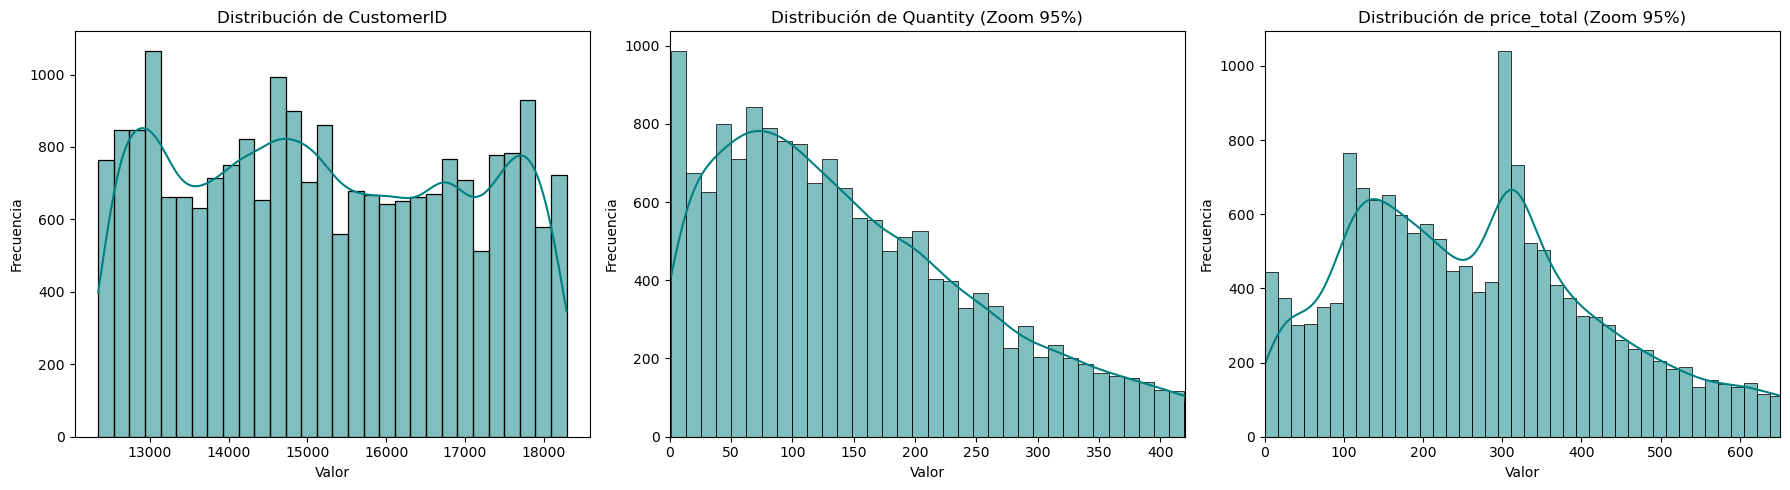

In [7]:
# Definimos el lienzo para 1 fila y 3 columnas
plt.figure(figsize=(18, 5))

# 1. Gráfico de CustomerID
plt.subplot(1, 3, 1)
sns.histplot(df['CustomerID'], kde=True, color='teal', bins=30)
plt.title('Distribución de CustomerID')
plt.xlabel('Valor')
plt.ylabel('Frecuencia')

# 2. Gráfico de Quantity (con zoom al 95%)
plt.subplot(1, 3, 2)
sns.histplot(df_final['Quantity'], kde=True, color='teal', bins=50)
plt.xlim(0, df_final['Quantity'].quantile(0.95))
plt.title('Distribución de Quantity (Zoom 95%)')
plt.xlabel('Valor')
plt.ylabel('Frecuencia')

# 3. Gráfico de price_total (con zoom al 95%)
plt.subplot(1, 3, 3)
sns.histplot(df_final['price_total'], kde=True, color='teal', bins=50)
plt.xlim(0, df_final['price_total'].quantile(0.95))
plt.title('Distribución de price_total (Zoom 95%)')
plt.xlabel('Valor')
plt.ylabel('Frecuencia')

# Ajuste automático de espacios y mostrar
plt.tight_layout()
plt.show()

#### Análisis de Distribución (Zoom 95%)

La visualización ajustada permite observar el comportamiento real de la operación, eliminando la distorsión provocada por valores atípicos extremos.

#### Hallazgos por variable

**CustomerID**  
Presenta una distribución multimodal y relativamente uniforme. Esto indica que no existe un grupo reducido de clientes que concentre la operación, sino una base de clientes distribuida de manera homogénea.

**Quantity (Zoom 95%)**  
Muestra una distribución con sesgo positivo. La mayoría de los pedidos se concentran entre 1 y 150 unidades, con un pico cercano a las 80 unidades. Este patrón es consistente con un comportamiento típico de ventas retail.

**price_total (Zoom 95%)**  
Presenta una distribución bimodal. Se observan dos picos relevantes: uno alrededor de 150 y otro más alto cercano a 320. Esto sugiere la existencia de dos tickets promedio o combinaciones de productos que funcionan como principales generadores de ventas.

#### Conclusión técnica

Al limitar el eje X, el estimador de densidad (KDE) logra representar correctamente la probabilidad de los datos. Si bien existen transacciones extremadamente grandes, el núcleo del negocio se concentra en operaciones con cantidades inferiores a 400 unidades y montos menores a 600 en precio.

------
#### Análisis de Correlación

----

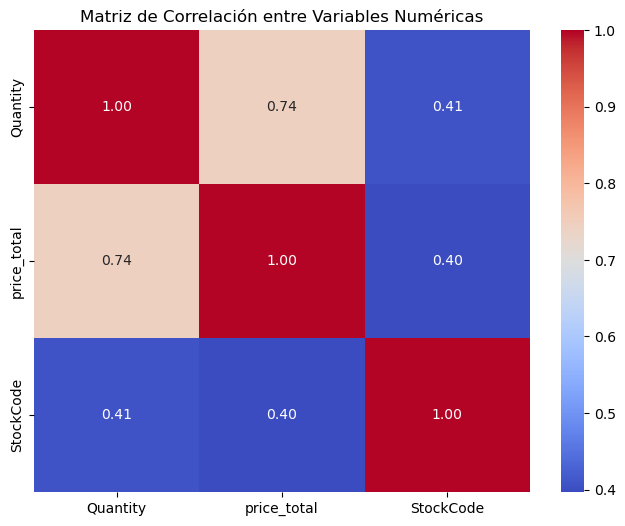


Matriz de Correlación:
             Quantity  price_total  StockCode
Quantity     1.000000     0.744026   0.406745
price_total  0.744026     1.000000   0.396564
StockCode    0.406745     0.396564   1.000000


In [8]:
#Análisis de Correlación
# Seleccionamos variables numéricas relevantes (omitimos IDs para que la matriz sea útil)
cols_interes = ['Quantity', 'price_total', 'StockCode']
corr_matrix = df_final[cols_interes].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación entre Variables Numéricas')
plt.show()

print("\nMatriz de Correlación:")
print(corr_matrix)

In [9]:
# Eliminar filas duplicadas solo como medida de seguridad antes de aplicar clustering, aunque no es común que existan en este tipo de datos.
df_final = df.drop_duplicates()

---
#### 2. Generación de variables para segmentación

---

La granularidad de la data es a nivel de boleta, pero la segmentación debe realizarse a nivel de cliente.

Se solicita generar variables agregadas por cliente. Como mínimo, incluir variables RFM:

- Recencia (Recency)
- Frecuencia (Frequency)
- Monto (Monetary)

Pueden incorporarse variables adicionales si se considera pertinente.

Explicar claramente cómo se construye cada variable.

In [10]:
# Creamos nuestra variable de año-mes a partir de la fecha de la factura para luego calcular la cantidad de meses distintos en los que cada cliente ha comprado.
df_final['ano_mes'] = df_final['InvoiceDate'].dt.to_period('M')

# Para calcular la recencia, necesitamos una fecha de referencia. Usaremos el día siguiente a la última fecha de compra registrada en el dataset.
ref_date = df_final['InvoiceDate'].max() + pd.Timedelta(days=1)

# Agrupamos por CustomerID y calculamos las métricas necesarias para el análisis RFM y otras características relevantes.
data_seg = df_final.groupby('CustomerID').agg(
    ult_compra = ('InvoiceDate', 'max'),
    frecuencia = ('InvoiceNo', 'count'),
    cantidad_promedio = ('Quantity', 'mean'),
    cantidad_total = ('Quantity', 'sum'),
    monto_promedio = ('price_total', 'mean'),
    monto_total = ('price_total', 'sum'),
    articulos_distintos_promedio = ('StockCode', 'mean'),
    distintos_meses = ('ano_mes', 'nunique')
)

# Calculamos la recencia en días a partir de la fecha de referencia y la última compra de cada cliente.
data_seg['recencia_dias'] = (pd.to_datetime(ref_date) - pd.to_datetime(data_seg['ult_compra'])).dt.days

# Revisamos las primeras filas del nuevo DataFrame con las métricas calculadas para cada cliente.
data_seg.head()

,ult_compra,frecuencia,cantidad_promedio,cantidad_total,monto_promedio,monto_total,articulos_distintos_promedio,distintos_meses,recencia_dias
CustomerID,,,,,,,,,
12346,2011-01-18,2,0.000000,0,0.000000,0.00,1.00,1,326
12347,2011-12-07,7,351.142857,2458,615.714286,4310.00,26.00,7,3
12348,2011-09-25,4,585.250000,2341,449.310000,1797.24,7.75,4,76
12349,2011-11-21,1,631.000000,631,1757.550000,1757.55,73.00,1,19
12350,2011-02-02,1,197.000000,197,334.400000,334.40,17.00,1,311


In [11]:
# Seleccionamos solo las columnas numéricas relevantes para el clustering (RFM + otras características) y las almacenamos en X.
X = data_seg.loc[:, ['frecuencia', 'monto_promedio', 'recencia_dias']].copy()

# Estandarizamos las variables para que tengan media 0 y desviación estándar 1, lo cual es importante para algoritmos de clustering como KMeans.
scaler = StandardScaler()
# Luego de instanciar nuestro scaler, aplicamos fit_transform a X para obtener la versión estandarizada de nuestras variables.
X_scaled = scaler.fit_transform(X)
# Revisamos las primeras filas de X_scaled para asegurarnos de que todo esté correcto antes de proceder con el clustering.
print(pd.DataFrame(X_scaled, columns=X.columns).head())

   frecuencia  monto_promedio  recencia_dias
0   -0.329362       -0.874548       2.316568
1    0.206102        0.830106      -0.889050
2   -0.115176        0.369402      -0.164560
3   -0.436455        3.991369      -0.730258
4   -0.436455        0.051265       2.167700


In [12]:
# Volvemos a transformar el array resultante de la estandarización a un DataFrame para facilitar su manejo y visualización, asignándole nombres genéricos a las columnas por ahora.
data_clustering = pd.DataFrame(X_scaled, columns=['Frecuencia', 'Monto Promedio', 'Recencia'], index=X.index)
# Revisamos las primeras filas del DataFrame que usaremos para el clustering para asegurarnos de que todo esté correcto.
data_clustering.head()

,Frecuencia,Monto Promedio,Recencia
CustomerID,,,
12346,-0.329362,-0.874548,2.316568
12347,0.206102,0.830106,-0.889050
12348,-0.115176,0.369402,-0.164560
12349,-0.436455,3.991369,-0.730258
12350,-0.436455,0.051265,2.167700


---
#### K-Means
---

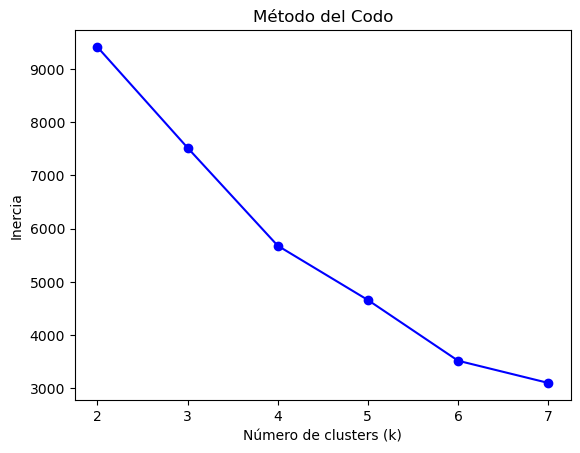

In [13]:
# Definir una lista de posibles valores de k para el método del codo
k_values = range(2, 8)

# Vamos a calcular la inercia para diferentes valores de k (número de clusters) para luego usar el método del codo y determinar el número óptimo de clusters para nuestro análisis.
inertia_values = []
# Realizar clustering con diferentes valores de k y calcular las métricas
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_clustering)
    labels = kmeans.labels_
    # Calcular la inercia
    inertia_values.append(kmeans.inertia_)

# Graficar el método del codo utilizando la inercia
plt.plot(k_values, inertia_values, 'bo-')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inercia')
plt.title('Método del Codo')
plt.show()

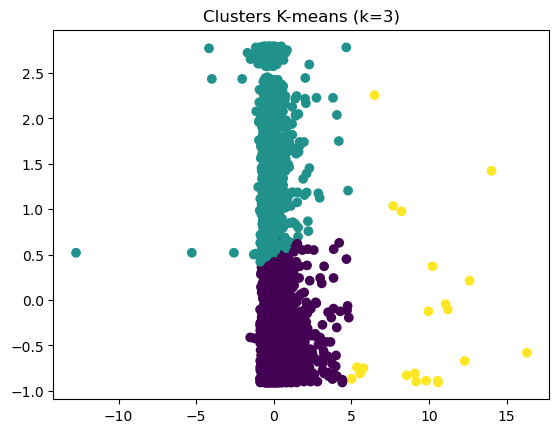

In [14]:
# Realizar clustering con el valor óptimo de k (elegido por el método del codo)
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(data_clustering)
labels = kmeans.labels_
data_clustering['clusters'] = labels


# Graficar los clusters en el espacio reducido por PCA
plt.scatter(data_clustering.iloc[:, 1], data_clustering.iloc[:, 2], c=labels)
#plt.xlabel('Componente Principal 1')
#plt.ylabel('Componente Principal 2')
plt.title('Clusters K-means (k=3)')
plt.show()


--- 
#### Fuzzy K Means

---

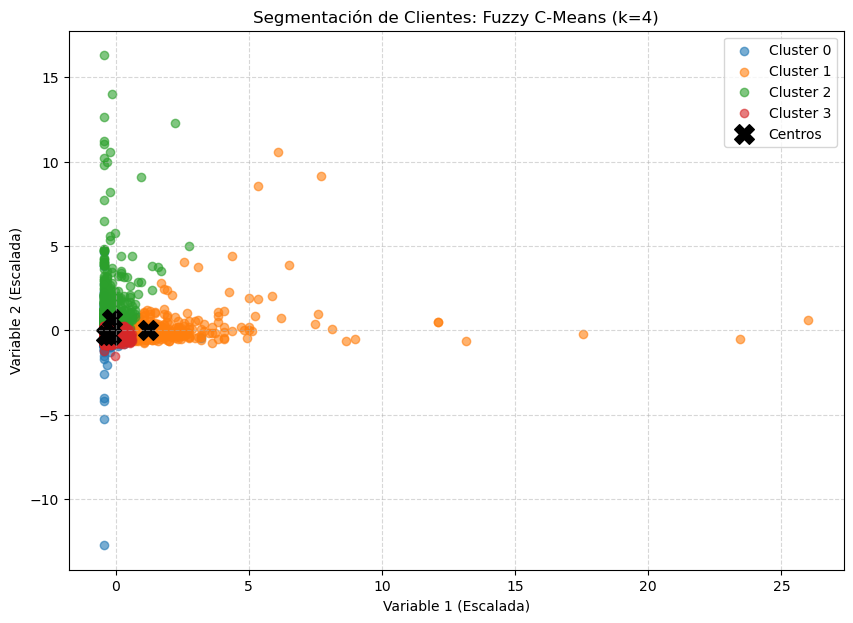

In [15]:
# Vamos a ejecutar un Fuzzy K Means como alternativa al KMeans tradicional para ver si obtenemos una segmentación más difusa y quizás más realista de nuestros clientes. 
# Este método asigna a cada cliente una probabilidad de pertenencia a cada cluster, en lugar de asignarlos de manera rígida a un solo cluster como hace KMeans.
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    data_clustering.T.values, c=4, m=2, error=0.005, maxiter=1000, init=None
)

# 2. Asignar resultados
cluster_membership = np.argmax(u, axis=0)
data_clustering['Fuzzy_Cluster'] = cluster_membership

# 3. Graficar con la corrección de indexación
plt.figure(figsize=(10, 7))

# Obtenemos los centros de los clusters (cntr) que ya están en el formato correcto para graficar.
x_axis = data_clustering.iloc[:, 0] 
y_axis = data_clustering.iloc[:, 1]

# Graficar cada cluster
for j in range(4):
    plt.scatter(x_axis[cluster_membership == j],
                y_axis[cluster_membership == j],
                label=f'Cluster {j}', alpha=0.6)

# Graficar los centros
plt.scatter(cntr[:, 0], cntr[:, 1], marker='X', s=200, c='black', label='Centros')

plt.title('Segmentación de Clientes: Fuzzy C-Means (k=4)')
plt.xlabel('Variable 1 (Escalada)')
plt.ylabel('Variable 2 (Escalada)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

---
#### Midiendo desempeño
---

In [16]:
# Score para K-Means
score_km = silhouette_score(data_clustering, data_clustering['clusters'])

# Score para Fuzzy C-Means
score_fcm = silhouette_score(data_clustering, data_clustering['Fuzzy_Cluster'])

print(f"Ganador Matemático:")
print(f"Silhouette K-Means: {score_km:.4f}")
print(f"Silhouette Fuzzy C-Means: {score_fcm:.4f}")

Ganador Matemático:
Silhouette K-Means: 0.6067
Silhouette Fuzzy C-Means: 0.5727


In [17]:
# Definimos las columnas que queremos analizar (Recency, Frequency, Monetary, etc.)
cols_analisis = ['Frecuencia', 'Monto Promedio', 'Recencia'] 

print("Perfil de Clusters: K-Means")
print(data_clustering.groupby('clusters')[cols_analisis].mean())

print("\nPerfil de Clusters: Fuzzy C-Means")
print(data_clustering.groupby('Fuzzy_Cluster')[cols_analisis].mean())


Perfil de Clusters: K-Means
          Frecuencia  Monto Promedio  Recencia
clusters                                      
0           0.110945        0.013313 -0.518084
1          -0.345091       -0.220194  1.528905
2           0.965952        9.506377 -0.173540

Perfil de Clusters: Fuzzy C-Means
               Frecuencia  Monto Promedio  Recencia
Fuzzy_Cluster                                      
0               -0.344253       -0.257447  1.537320
1                1.764006        0.072942 -0.768209
2               -0.161136        1.167076 -0.347785
3               -0.158147       -0.292923 -0.506361


---
#### Conclusiones
---

#### Resumen de lo que nos dicen los datos

#### 1. K-Means: El modelo "Agresivo" (k = 4)

K-Means ha agrupado a los clientes en tres categorías muy marcadas por los extremos:

- **Cluster 2 (Los VIP / Outliers):**  
  Tienen un Monto Promedio altísimo (9.50). Son nuestros “Whales” o clientes corporativos que gastan muchísimo más que el resto.

- **Cluster 1 (Los Perdidos):**  
  Tienen la Recencia más alta (1.52). Son clientes que no han comprado hace mucho tiempo y su frecuencia es negativa (muy por debajo de la media).

- **Cluster 0 (Los Promedio):**  
  Un grupo híbrido con métricas muy cercanas a cero (la media), pero con recencia negativa, lo que indica que son clientes activos pero de bajo valor.


#### 2. Fuzzy C-Means: El modelo "Estratégico" (k = 4)

Este modelo es superior para nuestro reporte porque logra separar el “ruido” y encontrar un grupo que K-Means ignoró:

- **Cluster 1 (Los Fieles / Frecuentes):**  
  Tienen la mayor Frecuencia (1.76) y la mejor Recencia (-0.76, es decir, compraron muy recientemente).  
  No son los que más gastan por compra, pero son tus clientes más constantes.

- **Cluster 3 (Los de Alto Ticket):**  
  Tienen un Monto Promedio alto (1.16).  
  A diferencia del Cluster 2 de K-Means (un outlier extremo), este parece ser un grupo premium más “real” y accionable con campañas.

- **Cluster 2 (Los Inactivos):**  
  Muy similar al Cluster 1 de K-Means. Clientes que ya se fueron o están a punto de hacerlo (Recencia 1.53).

- **Cluster 0 (Nuevos o de Paso):**  
  Clientes con frecuencia y monto bajos, pero recencia negativa (activos).


#### Comparativa Final

| Característica       | K-Means                                                | Fuzzy C-Means                                              |
|----------------------|--------------------------------------------------------|------------------------------------------------------------|
| Sensibilidad         | Se deja llevar por valores extremos (Monto 9.50)       | Reparte mejor el valor entre frecuencia y monto            |
| Utilidad Marketing   | Difícil de usar; el Cluster 0 es demasiado general     | Excelente; separa claramente “frecuencia” de “gasto alto”  |
| Recomendación        | Úsalo solo para identificar outliers puros             | Ideal para entrega; permite 4 estrategias diferenciadas    |

#### Conclusión de la evaluación

Nos quedamos con **Fuzzy C-Means**.  
El hecho de que haya detectado el Cluster 1 (alta frecuencia y muy reciente) lo vuelve muy valioso para programas de lealtad (K-Means simplemente mezcló con los demás).

---
#### Interpretación y caracterización de segmentos
---

A partir de los algoritmos de clustering aplicados, se identificaron distintos grupos de clientes con comportamientos de compra diferenciados. Para su interpretación se analizaron principalmente las variables RFM (Recencia, Frecuencia y Monto), además de las variables complementarias generadas.

El objetivo de esta etapa es traducir los resultados técnicos en segmentos útiles para la toma de decisiones de negocio.

---

#### Cluster 0 — Clientes VIP o de Alto Valor

**Características principales:**

- Baja recencia (compras recientes)  
- Alta frecuencia de compra  
- Alto monto total gastado  
- Alta actividad sostenida  

**Interpretación:**

Este grupo representa a los clientes más valiosos del supermercado. Compran con frecuencia, gastan más que el promedio y mantienen una relación activa con la empresa.

**Estrategias recomendadas:**

- Programas de fidelización premium  
- Descuentos exclusivos  
- Acceso anticipado a promociones  
- Recomendaciones personalizadas  
- Beneficios por volumen de compra  


#### Cluster 1 — Clientes Ocasionales

**Características principales:**

- Frecuencia media o baja  
- Monto moderado  
- Recencia variable  

**Interpretación:**

Son clientes que compran de forma esporádica. No presentan un alto compromiso con la tienda, pero tampoco están completamente inactivos.

**Estrategias recomendadas:**

- Promociones dirigidas para aumentar frecuencia  
- Cupones de descuento por próximas compras  
- Campañas de recordatorio  
- Ofertas por categorías preferidas  


#### Cluster 2 — Clientes en Riesgo o Inactivos

**Características principales:**

- Alta recencia (no compran hace tiempo)  
- Baja frecuencia  
- Bajo monto total  

**Interpretación:**

Este segmento agrupa a clientes que han reducido significativamente su actividad o han dejado de comprar. Representan una oportunidad de reactivación.

**Estrategias recomendadas:**

- Campañas de recuperación (“te extrañamos”)  
- Descuentos agresivos por tiempo limitado  
- Incentivos para primera compra de retorno  
- Encuestas para identificar causas de abandono  


#### Cluster 3 — Clientes Nuevos o de Bajo Valor

**Características principales:**

- Baja frecuencia  
- Bajo monto acumulado  
- Recencia baja (compras recientes pero pocas)  

**Interpretación:**

Son clientes recientes o con baja interacción histórica. Aún no han desarrollado un patrón claro de consumo.

**Estrategias recomendadas:**

- Programas de bienvenida  
- Incentivos para segunda compra  
- Promociones iniciales  
- Comunicación orientada a descubrimiento de productos  

---
#### Conclusión de la segmentación
---

La segmentación obtenida permite comprender la heterogeneidad del comportamiento de los clientes de FreshMart. En lugar de tratar a todos los consumidores de forma uniforme, la empresa puede diseñar estrategias diferenciadas que maximicen la satisfacción del cliente y la rentabilidad.

Los clientes VIP deben ser retenidos mediante beneficios exclusivos, los clientes ocasionales pueden ser estimulados para aumentar su frecuencia, mientras que los clientes inactivos requieren campañas específicas de reactivación. Por su parte, los clientes nuevos representan una oportunidad de crecimiento si se logra consolidar su relación con la marca.

Esta segmentación constituye una herramienta clave para la personalización de campañas de marketing, optimización de recursos y mejora de la experiencia del cliente.


**Realizado por** Ignacio Robles, como parte del curso de Machine Learning de Desafío Latam.